In [55]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import shutil
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use(u'nbAgg')
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from prettytable import PrettyTable


<h3>1. Exploratory Data Analysis</h3>

<h4>1.1 Separating byte files and asm files </h4>


In [ ]:

source = 'train'
destination = 'byteFiles'

# we will check if the folder 'byteFiles' exists if it not there we will create a folder with the same name
if not os.path.isdir(destination):
    os.makedirs(destination)

# if we have folder called 'train' (train folder contains both .asm files and .bytes files) we will rename it 'asmFiles'
# for every file that we have in our 'asmFiles' directory we check if it is ending with .bytes, if yes we will move it to
# 'byteFiles' folder

# so by the end of this snippet we will separate all the .byte files and .asm files
if os.path.isdir(source):
    os.rename(source,'asmFiles')
    source='asmFiles'
    data_files = os.listdir(source)
    for file in data_files:
        if (file.endswith("bytes")):
            shutil.move(os.path.join(source, file), os.path.join(destination, file))

<h4>1.2 Distribution of malware classes in whole data set </h4>


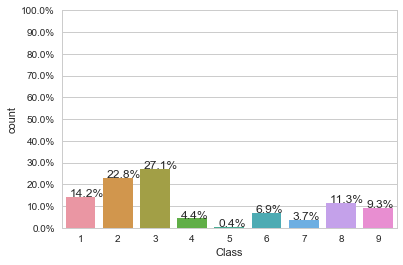

In [2]:
sns.set(style="whitegrid")
Y=pd.read_csv("trainLabels.csv")
total = len(Y)*1.
ax=sns.countplot(x="Class", data=Y)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

<pre>
Majority classes in our dataset are 3,2,1 and Minority classes are 5,7,4
</pre>

<h4>1.3 Feature extraction </h4>


<h4>1.3.1 File size  of ASM files as a feature </h4>

In [3]:
#file sizes of byte files
files=os.listdir('asmFiles')
filenames=Y['Id'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('asmFiles/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
asm_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes})
print (asm_size_byte.head())

   Class                    ID       size
0      9  01azqd4InC7m9JpocGv5  56.229886
1      2  01IsoiSMh5gxyDYTl4CB  13.999378
2      9  01jsnpXSAlgw6aPeDxrU   8.507785
3      1  01kcPWA9K2BOxQeS5Rju   0.078190
4      8  01SuzwMJEIXsK7A8dQbl   0.996723


<h4>1.3.2 Box plots of file size (.asm files) feature </h4>

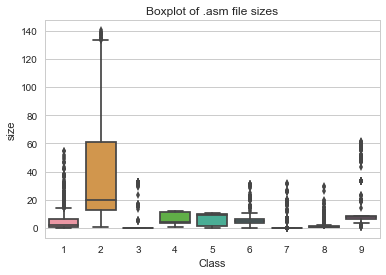

In [4]:
#boxplot of byte files
ax = sns.boxplot(x="Class", y="size", data=asm_size_byte)
plt.title("Boxplot of .asm file sizes")
plt.show()

<pre>
The plot is between .asm file sizes and class 
75 percentile of class 2 files are of size 60MB
</pre>

<h2> PART 1 </h2>

<h4>1.1 Feature extraction from asm files </h4>


<p>
<li> To extract the unigram features from the .asm files we need to process ~150GB of data </li>
<li style="font-size:18px"><b>Note: Below two cells will take lot of time (over 48 hours to complete)</b></li>
<li> We will provide you the output file of these two cells, which you can directly use it </li>
</p>

In [ ]:
#intially create five folders
#first 
#second
#thrid
#fourth
#fifth
#this code tells us about random split of files into five folders
folder_1 ='first'
folder_2 ='second'
folder_3 ='third'
folder_4 ='fourth'
folder_5 ='fifth'
folder_6 = 'output'
for i in [folder_1,folder_2,folder_3,folder_4,folder_5,folder_6]:
    if not os.path.isdir(i):
        os.makedirs(i)

source='asmFiles/'
files = os.listdir('asmFiles')
#ID=df['Id'].tolist()
data=range(0,10868)
#r.shuffle(data)
#count=0
for i in range(0,10868):
    if i % 5==0:
        shutil.move(source+files[data[i]],'first')
    elif i%5==1:
        shutil.move(source+files[data[i]],'second')
    elif i%5 ==2:
        shutil.move(source+files[data[i]],'third')
    elif i%5 ==3:
        shutil.move(source+files[data[i]],'fourth')
    elif i%5==4:
        shutil.move(source+files[data[i]],'fifth')

In [ ]:
#http://flint.cs.yale.edu/cs421/papers/x86-asm/asm.html

def firstprocess():
    #The prefixes tells about the segments that are present in the asm files
    #There are 450 segments(approx) present in all asm files.
    #this prefixes are best segments that gives us best values.
    #https://en.wikipedia.org/wiki/Data_segment
    
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    #this are opcodes that are used to get best results
    #https://en.wikipedia.org/wiki/X86_instruction_listings
    
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    #best keywords that are taken from different blogs
    keywords = ['.dll','std::',':dword']
    #Below taken registers are general purpose registers and special registers
    #All the registers which are taken are best 
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open('output\Asmsmallfile.txt','w+')
    
    files = os.listdir('first')
    for f in files:
        #filling the values with zeros into the arrays
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        
        # https://docs.python.org/3/library/codecs.html#codecs.ignore_errors
        # https://docs.python.org/3/library/codecs.html#codecs.Codec.encode
        with codecs.open('first/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                # https://www.tutorialspoint.com/python3/string_rstrip.htm
                line=lines.rstrip().split()
                l=line[0]
                #counting the prefixs in each and every line
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                #counting the opcodes in each and every line
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                #counting registers in the line
                for i in range(len(registers)):
                    for li in line:
                        # we will use registers only in 'text' and 'CODE' segments
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                #counting keywords in the line
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        #pushing the values into the file after reading whole file
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
        
    
    file1.close()


#same as above 
def secondprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open('output\mediumasmfile.txt','w+')
    
    files = os.listdir('second')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        
        with codecs.open('second/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
        
    
    file1.close()

# same as smallprocess() functions
def thirdprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open('output\largeasmfile.txt','w+')
    
    files = os.listdir('third')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        
        with codecs.open('third/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
        
    
    file1.close()


def fourthprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open('output\hugeasmfile.txt','w+')
    
    files = os.listdir('fourth/')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        
        with codecs.open('fourth/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
        
    
    file1.close()


def fifthprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open('output\Trainasmfile.txt','w+')
    
    files = os.listdir('fifth/')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        
        with codecs.open('fifth/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
        
        
    file1.close()


def main():
    #the below code is used for multiprogramming
    #the number of process depends upon the number of cores present System
    #process is used to call multiprogramming

    manager=multiprocessing.Manager() 	
    p1=Process(target= firstprocess())
    p2=Process(target= secondprocess())
    p3=Process(target= thirdprocess())
    p4=Process(target= fourthprocess())
    p5=Process(target= fifthprocess())

    #p1.start() is used to start the thread execution
    p1.start()
    p2.start()
    p3.start()
    p4.start()
    p5.start()
    #After completion all the threads are joined
    p1.join()
    p2.join()
    p3.join()
    p4.join()
    p5.join()
if __name__=="__main__":
    

    main()
    


In [5]:
dfasm=pd.read_csv('C:\\Users\\Nishanth\\Anaconda3\\Untitled Folder\\microsoft malware detection\\output\\asmoutputfile.asm', names = ['ID','HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx','.dll','std::',':dword','edx','esi','eax','ebx','ecx','edi','ebp','esp','eip'])


In [6]:
dfasm.shape

(10868, 52)

In [7]:
dfasm = dfasm.reset_index()

In [8]:
dfasm.columns = ['ID','HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx','.dll','std::',':dword','edx','esi','eax','ebx','ecx','edi','ebp','esp','eip','a']

In [9]:
dfasm1 = dfasm.drop('a',axis=1)

In [10]:
data_size_byte1 = asm_size_byte[['Class','ID','size']]
result= pd.merge(dfasm1, data_size_byte1,on='ID', how='left')

In [11]:
result.head()

,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,esi,eax,ebx,ecx,edi,ebp,esp,eip,Class,size
0,01azqd4InC7m9JpocGv5,18,22430,0,1158,1366754,0,1794,0,0,...,2290,1281,587,701,0,15,14,456,9,56.229886
1,02IOCvYEy8mjiuAQHax3,17,838,0,41,77840,0,0,0,3,...,11,9,7,15,0,6,0,14,6,3.296968
2,02zcUmKV16Lya5xqnPGB,0,8630,0,312,25277,0,963518,0,0,...,1156,472,749,437,0,10,18,75,2,36.020807
3,04hSzLv5s2TDYPlcgpHB,18,9247,0,245,6325,0,0,0,3,...,941,17,1427,98,0,18,0,93,8,1.010420
4,05EeG39MTRrI6VY21DPd,17,11119,0,323,1047,0,3385,0,3,...,1378,610,446,732,0,20,45,85,1,0.935457


<h4>1.2 Univariate analysis on  asm file features</h4>

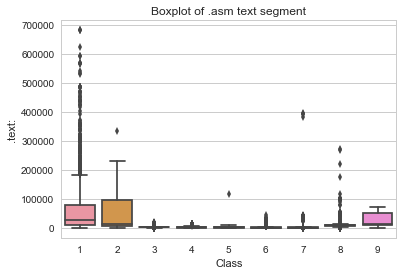

In [12]:
ax = sns.boxplot(x="Class", y=".text:", data=result)
plt.title("Boxplot of .asm text segment")
plt.show()

<pre>
The plot is between Text and class 
Class 1,2 and 9 can be easly separated
</pre>

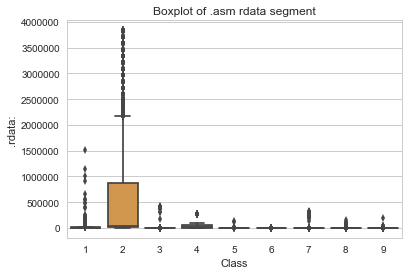

In [13]:
ax = sns.boxplot(x="Class", y=".rdata:", data=result)
plt.title("Boxplot of .asm rdata segment")
plt.show()

<pre>
The plot is between rdata and class 
Class 2 can be easily separated 75 percentile files are having close to 1M rdata lines
</pre>

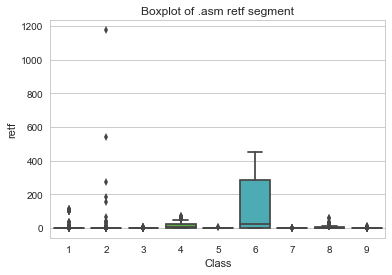

In [14]:
ax = sns.boxplot(x="Class", y="retf", data=result)
plt.title("Boxplot of .asm retf segment")
plt.show()

<pre>
The plot is between retf and class 
Class 6 can be easly separated 75 percentile files are having 300 retf lines
</pre>

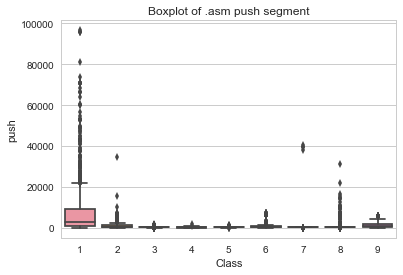

In [15]:
ax = sns.boxplot(x="Class", y="push", data=result)
plt.title("Boxplot of .asm push segment")
plt.show()

<pre>
The plot is between push and class 
Class 1 can be easly separated 75 percentile files are having 10000 push lines
</pre>

In [16]:
# https://stackoverflow.com/a/29651514
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1


In [17]:
# we normalize the data each column 
result = normalize(result)
result.head()

,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,esi,eax,ebx,ecx,edi,ebp,esp,eip,Class,size
0,01azqd4InC7m9JpocGv5,0.101695,0.032927,0.0,0.006937,0.542847,0.0,0.000467,0.0,0.000000,...,0.025875,0.025744,0.004910,0.008930,0.0,0.027174,0.000428,0.049896,9,0.400910
1,02IOCvYEy8mjiuAQHax3,0.096045,0.001230,0.0,0.000246,0.030916,0.0,0.000000,0.0,0.000072,...,0.000124,0.000181,0.000059,0.000191,0.0,0.010870,0.000000,0.001532,6,0.023389
2,02zcUmKV16Lya5xqnPGB,0.000000,0.012669,0.0,0.001869,0.010040,0.0,0.250934,0.0,0.000000,...,0.013062,0.009486,0.006265,0.005567,0.0,0.018116,0.000550,0.008207,2,0.256777
3,04hSzLv5s2TDYPlcgpHB,0.101695,0.013575,0.0,0.001468,0.002512,0.0,0.000000,0.0,0.000072,...,0.010632,0.000342,0.011937,0.001248,0.0,0.032609,0.000000,0.010176,8,0.007081
4,05EeG39MTRrI6VY21DPd,0.096045,0.016323,0.0,0.001935,0.000416,0.0,0.000882,0.0,0.000072,...,0.015570,0.012259,0.003731,0.009325,0.0,0.036232,0.001376,0.009301,1,0.006546


<h4>1.3 Multivariate Analysis on .asm file features </h4>


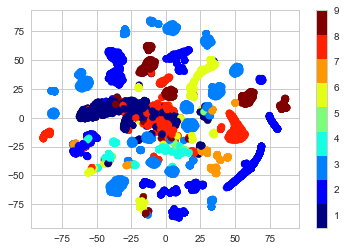

In [18]:
data_y = result['Class']
xtsne=TSNE(perplexity=50)
results=xtsne.fit_transform(result.drop(['ID','Class'], axis=1).fillna(0))
vis_x = results[:, 0]
vis_y = results[:, 1   ]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

<pre>
TSNE for asm data with perplexity 50
</pre>

<h3>1.4 Train and test split</h3>


In [20]:
asm_y = result['Class']
asm_x = result.drop(['ID','Class','.BSS:','rtn','.CODE'], axis=1)

In [22]:
X_train_asm, X_test_asm, y_train_asm, y_test_asm = train_test_split(asm_x,asm_y ,stratify=asm_y,test_size=0.20,random_state=42)
X_train_asm, X_cv_asm, y_train_asm, y_cv_asm = train_test_split(X_train_asm, y_train_asm,stratify=y_train_asm,test_size=0.20,random_state=52)

In [23]:
print('Number of data points in train data:', X_train_asm.shape[0])
print('Number of data points in test data:', X_test_asm.shape[0])
print('Number of data points in cross validation data:', X_cv_asm.shape[0])

Number of data points in train data: 6955
Number of data points in test data: 2174
Number of data points in cross validation data: 1739


In [24]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

<h3>1.5 Machine Learning models on features of .asm files</h3>


<h4>1.5.1 K-Nearest Neigbors </h4>


log_loss for k =  1 is 0.10633930599286752
log_loss for k =  3 is 0.10612552733905531
log_loss for k =  5 is 0.11930751982219175
log_loss for k =  7 is 0.12912345679070164
log_loss for k =  9 is 0.13708802581332247
log_loss for k =  11 is 0.14381830583306018
log_loss for k =  13 is 0.1503002596877297
log_loss for k =  15 is 0.15838663627922822
log_loss for k =  17 is 0.16529201330351267
log_loss for k =  19 is 0.17423148997748797


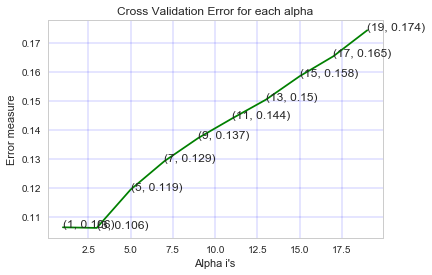

log loss for train data 0.04813934049319134
log loss for cv data 0.10612552733905531
log loss for test data 0.10002440307365187
Number of misclassified points  2.2079116835326587
-------------------------------------------------- Confusion matrix --------------------------------------------------


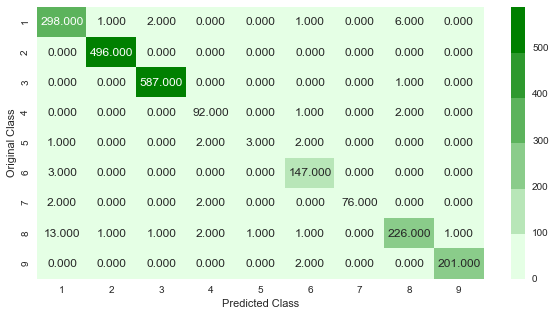

-------------------------------------------------- Precision matrix --------------------------------------------------


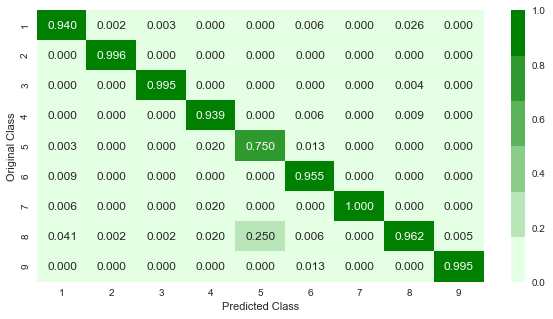

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


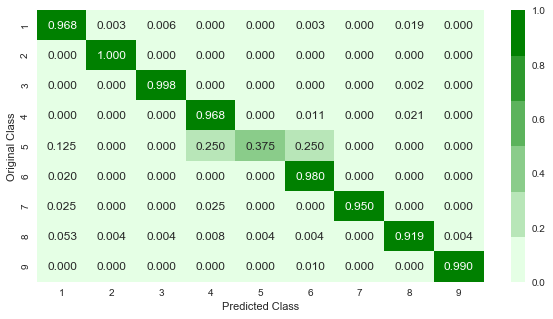

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [26]:
alpha = [x for x in range(1, 21,2)]
cv_log_error_array=[]
for i in alpha:
    k_cfl=KNeighborsClassifier(n_neighbors=i)
    k_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=k_cfl.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

k_cfl=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
k_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
pred_y=sig_clf.predict(X_test_asm)


predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',log_loss(y_train_asm, predict_y))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',log_loss(y_cv_asm, predict_y))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',log_loss(y_test_asm, predict_y))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

<h4>1.5.2 Logistic Regression </h4>


log_loss for c =  1e-05 is 1.5879044230798853
log_loss for c =  0.0001 is 1.545020801621372
log_loss for c =  0.001 is 1.2848863558723604
log_loss for c =  0.01 is 1.3247388206013748
log_loss for c =  0.1 is 1.1672613169547605
log_loss for c =  1 is 0.783084790684231
log_loss for c =  10 is 0.5583024290300623
log_loss for c =  100 is 0.41928861651371746
log_loss for c =  1000 is 0.35265151288161095


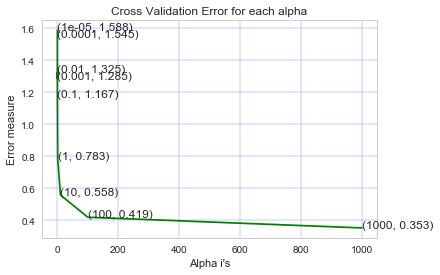

log loss for train data 0.3178820304949008
log loss for cv data 0.35265151288161095
log loss for test data 0.3244404285640497
Number of misclassified points  6.439742410303588
-------------------------------------------------- Confusion matrix --------------------------------------------------


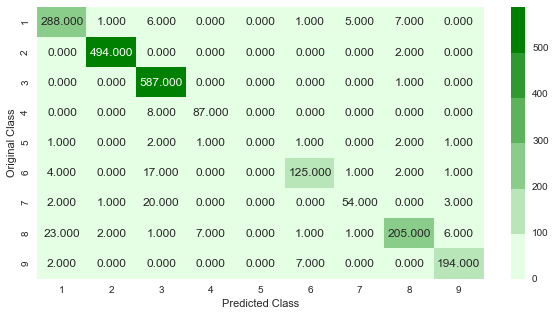

-------------------------------------------------- Precision matrix --------------------------------------------------


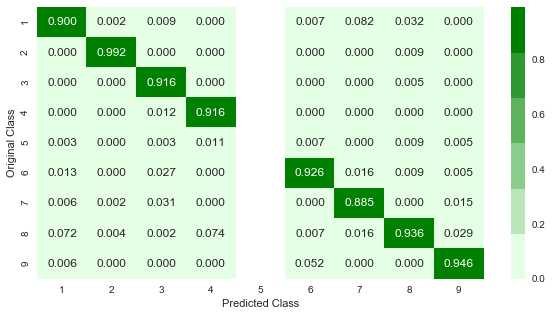

Sum of columns in precision matrix [ 1.  1.  1.  1. nan  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


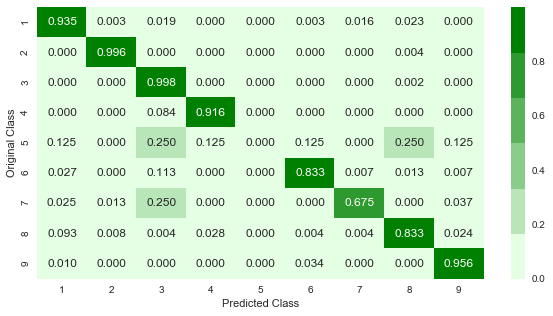

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [28]:
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)

predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',(log_loss(y_train_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',(log_loss(y_cv_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',(log_loss(y_test_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

<h4> 1.5.3 Random Forest Classifier</h4>


log_loss for c =  10 is 0.043453544144454945
log_loss for c =  50 is 0.03964285826208448
log_loss for c =  100 is 0.03895678710112629
log_loss for c =  500 is 0.0385151285637899
log_loss for c =  1000 is 0.03816651984149216
log_loss for c =  2000 is 0.038371118399709664
log_loss for c =  3000 is 0.03842510914792308


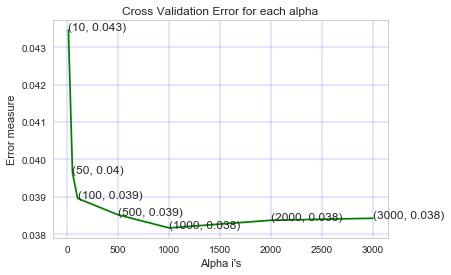

log loss for train data 0.013472021710787126
log loss for cv data 0.03816651984149216
log loss for test data 0.0489327575262548
Number of misclassified points  0.9199632014719411
-------------------------------------------------- Confusion matrix --------------------------------------------------


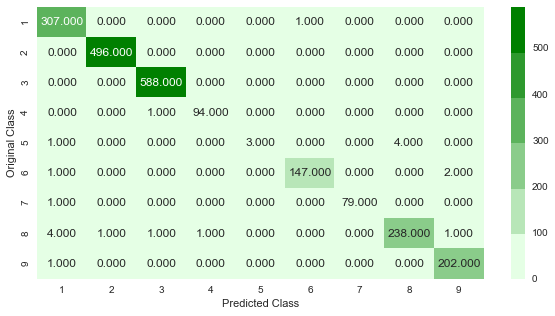

-------------------------------------------------- Precision matrix --------------------------------------------------


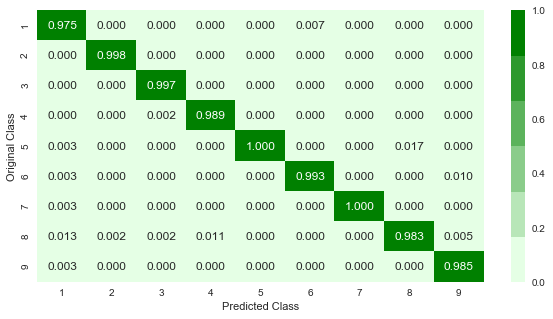

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


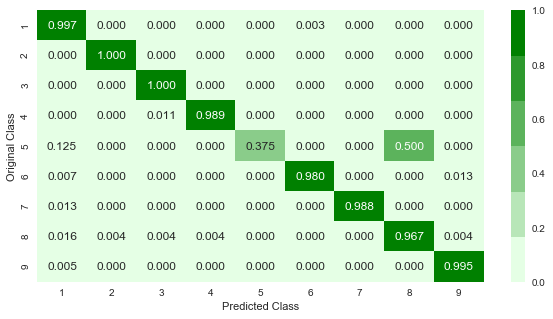

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [29]:
alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',(log_loss(y_train_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',(log_loss(y_cv_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',(log_loss(y_test_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

<h4> 1.5.4 XgBoost Classifier</h4>


log_loss for c =  10 is 0.0953665255471458
log_loss for c =  50 is 0.04341302883992383
log_loss for c =  100 is 0.03579955666448032
log_loss for c =  500 is 0.033916914078762066
log_loss for c =  1000 is 0.03458363474793327
log_loss for c =  2000 is 0.03512041910006649
log_loss for c =  3000 is 0.0355093316039902


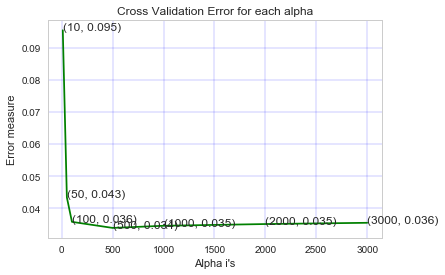

For values of best alpha =  500 The train log loss is: 0.011883349864957288
For values of best alpha =  500 The cross validation log loss is: 0.033916914078762066
For values of best alpha =  500 The test log loss is: 0.04670729045359764
Number of misclassified points  0.6899724011039559
-------------------------------------------------- Confusion matrix --------------------------------------------------


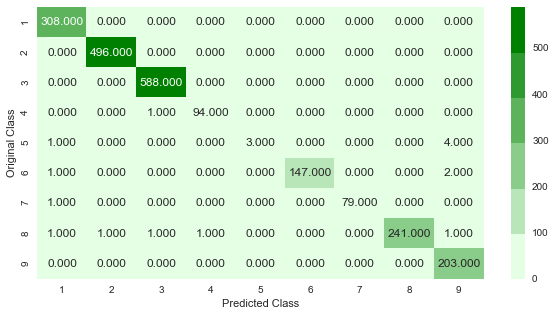

-------------------------------------------------- Precision matrix --------------------------------------------------


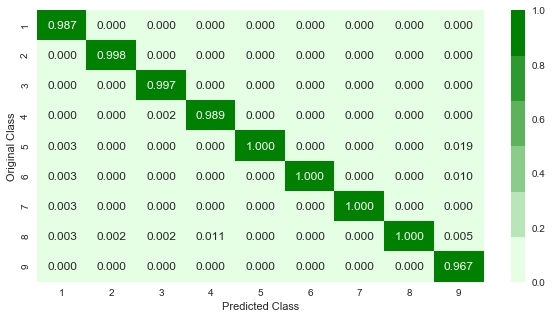

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


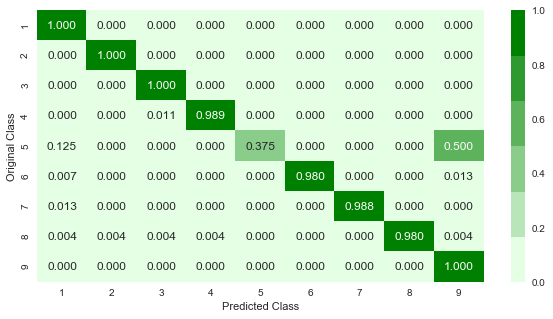

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [31]:
alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
    
predict_y = sig_clf.predict_proba(X_train_asm)

print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_asm, predict_y))
predict_y = sig_clf.predict_proba(X_cv_asm)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_asm, predict_y))
predict_y = sig_clf.predict_proba(X_test_asm)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_asm, predict_y))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

<h2> PART 2</h2>


<h3>2. Exploratory Data Analysis</h3>


<h4> 2.1 Feature extraction from asm files </h4>


In [ ]:
def firstprocess():
    #The prefixes tells about the segments that are present in the asm files
    #There are 450 segments(approx) present in all asm files.
    #this prefixes are best segments that gives us best values.
    #https://en.wikipedia.org/wiki/Data_segment
    
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','BSS:','CODE','DATA','code:','.adata:','.Tls:','.zenc:','.CRT:','U7h__u_:','GAP:','AppShare:','.rata:','YqLqNB:','.Lh:','.gnu_deb:','seg000:']
    #this are opcodes that are used to get best results
    #https://en.wikipedia.org/wiki/X86_instruction_listings
    
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or','shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx','al','bt','cdq','cld','cli','cmc','const','cwd','daa','db','dd','dw','endp','ends','faddp','fchs','fdiv','fdivp','fdivr','fild','fistp','fld','fstcw','fstcwimul','fstp','fword','fxch','in','ins','int','jb','je','jg','jge','jl','jno','jnz','jo','lea','loope','mul','near','neg','not','out','outs','popf','proc','pushf','rcl','rcr','rdtsc','rep','ret','sal','sar','sbb','scas','setb','setle','setnle','setnz','setz','shld','sidt','stc','std','sti','stos','test','wait']
    #best keywords that are taken from different blogs
    keywords = ['.dll','std::',':dword','Virtual','Offset','loc','Import','Imports','var','Forwarder','UINT','LONG','BOOL','WORD','BYTES','large','short','dd','db','dw','XREF','ptr','DATA','FUNCTION','extrn','byte','word','dword','char','DWORD','stdcall','arg','locret','asc','align','WinMain','unk','cookie','off','nullsub','DllEntryPoint','System32','dll','CHUNK','BASS','HMENU','DLL','LPWSTR','void','HRESULT','HDC','LRESULT','HANDLE','HWND','LPSTR','int','HLOCAL','FARPROC','ATOM','HMODULE','WPARAM','HGLOBAL','entry','rva','COLLAPSED','config','exe','Software','CurrentVersion','__imp_','INT_PTR','UINT_PTR','---Seperator','PCCTL_CONTEXT','__IMPORT_','INTERNET_STATUS_CALLBACK','case','installdir','market','microsoft','policies','proc','scrollwindow','search','trap','visualc','___security_cookie','assume','callvirtualalloc','exportedentry','hardware','hkey_current_user','hkey_local_machine','sp-analysisfailed','unableto']
    
    #Below taken registers are general purpose registers and special registers
    #All the registers which are taken are best 
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip','es','fs','ds','ss','gs','cs','ah','al','ax','bh','bl','bx','ch','cl','cx','dh','dl','dx']

    file1=open('output1\Asmsmallfile.txt','w+')
    
    files = os.listdir('first')
    for f in files:
        #filling the values with zeros into the arrays
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        
        # https://docs.python.org/3/library/codecs.html#codecs.ignore_errors
        # https://docs.python.org/3/library/codecs.html#codecs.Codec.encode
        with codecs.open('first/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                # https://www.tutorialspoint.com/python3/string_rstrip.htm
                line=lines.rstrip().split()
                l=line[0]
                #counting the prefixs in each and every line
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                #counting the opcodes in each and every line
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                #counting registers in the line
                for i in range(len(registers)):
                    for li in line:
                        # we will use registers only in 'text' and 'CODE' segments
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                #counting keywords in the line
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        #pushing the values into the file after reading whole file
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
        
    
    file1.close()


#same as above 
def secondprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','BSS:','CODE','DATA','code:','.adata:','.Tls:','.zenc:','.CRT:','U7h__u_:','GAP:','AppShare:','.rata:','YqLqNB:','.Lh:','.gnu_deb:','seg000:']
    opcodes =  ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or','shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx','al','bt','cdq','cld','cli','cmc','const','cwd','daa','db','dd','dw','endp','ends','faddp','fchs','fdiv','fdivp','fdivr','fild','fistp','fld','fstcw','fstcwimul','fstp','fword','fxch','in','ins','int','jb','je','jg','jge','jl','jno','jnz','jo','lea','loope','mul','near','neg','not','out','outs','popf','proc','pushf','rcl','rcr','rdtsc','rep','ret','sal','sar','sbb','scas','setb','setle','setnle','setnz','setz','shld','sidt','stc','std','sti','stos','test','wait']
    keywords = ['.dll','std::',':dword','Virtual','Offset','loc','Import','Imports','var','Forwarder','UINT','LONG','BOOL','WORD','BYTES','large','short','dd','db','dw','XREF','ptr','DATA','FUNCTION','extrn','byte','word','dword','char','DWORD','stdcall','arg','locret','asc','align','WinMain','unk','cookie','off','nullsub','DllEntryPoint','System32','dll','CHUNK','BASS','HMENU','DLL','LPWSTR','void','HRESULT','HDC','LRESULT','HANDLE','HWND','LPSTR','int','HLOCAL','FARPROC','ATOM','HMODULE','WPARAM','HGLOBAL','entry','rva','COLLAPSED','config','exe','Software','CurrentVersion','__imp_','INT_PTR','UINT_PTR','---Seperator','PCCTL_CONTEXT','__IMPORT_','INTERNET_STATUS_CALLBACK','case','installdir','market','microsoft','policies','proc','scrollwindow','search','trap','visualc','___security_cookie','assume','callvirtualalloc','exportedentry','hardware','hkey_current_user','hkey_local_machine','sp-analysisfailed','unableto']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip','es','fs','ds','ss','gs','cs','ah','al','ax','bh','bl','bx','ch','cl','cx','dh','dl','dx']

    file1=open('output1\mediumasmfile.txt','w+')
    
    files = os.listdir('second')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        
        with codecs.open('second/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
        
    
    file1.close()

# same as smallprocess() functions
def thirdprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','BSS:','CODE','DATA','code:','.adata:','.Tls:','.zenc:','.CRT:','U7h__u_:','GAP:','AppShare:','.rata:','YqLqNB:','.Lh:','.gnu_deb:','seg000:']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or','shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx','al','bt','cdq','cld','cli','cmc','const','cwd','daa','db','dd','dw','endp','ends','faddp','fchs','fdiv','fdivp','fdivr','fild','fistp','fld','fstcw','fstcwimul','fstp','fword','fxch','in','ins','int','jb','je','jg','jge','jl','jno','jnz','jo','lea','loope','mul','near','neg','not','out','outs','popf','proc','pushf','rcl','rcr','rdtsc','rep','ret','sal','sar','sbb','scas','setb','setle','setnle','setnz','setz','shld','sidt','stc','std','sti','stos','test','wait']
    keywords = ['.dll','std::',':dword','Virtual','Offset','loc','Import','Imports','var','Forwarder','UINT','LONG','BOOL','WORD','BYTES','large','short','dd','db','dw','XREF','ptr','DATA','FUNCTION','extrn','byte','word','dword','char','DWORD','stdcall','arg','locret','asc','align','WinMain','unk','cookie','off','nullsub','DllEntryPoint','System32','dll','CHUNK','BASS','HMENU','DLL','LPWSTR','void','HRESULT','HDC','LRESULT','HANDLE','HWND','LPSTR','int','HLOCAL','FARPROC','ATOM','HMODULE','WPARAM','HGLOBAL','entry','rva','COLLAPSED','config','exe','Software','CurrentVersion','__imp_','INT_PTR','UINT_PTR','---Seperator','PCCTL_CONTEXT','__IMPORT_','INTERNET_STATUS_CALLBACK','case','installdir','market','microsoft','policies','proc','scrollwindow','search','trap','visualc','___security_cookie','assume','callvirtualalloc','exportedentry','hardware','hkey_current_user','hkey_local_machine','sp-analysisfailed','unableto']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip','es','fs','ds','ss','gs','cs','ah','al','ax','bh','bl','bx','ch','cl','cx','dh','dl','dx']

    file1=open('output1\largeasmfile.txt','w+')
    
    files = os.listdir('third')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        
        with codecs.open('third/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
        
    
    file1.close()


def fourthprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','BSS:','CODE','DATA','code:','.adata:','.Tls:','.zenc:','.CRT:','U7h__u_:','GAP:','AppShare:','.rata:','YqLqNB:','.Lh:','.gnu_deb:','seg000:']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or','shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx','al','bt','cdq','cld','cli','cmc','const','cwd','daa','db','dd','dw','endp','ends','faddp','fchs','fdiv','fdivp','fdivr','fild','fistp','fld','fstcw','fstcwimul','fstp','fword','fxch','in','ins','int','jb','je','jg','jge','jl','jno','jnz','jo','lea','loope','mul','near','neg','not','out','outs','popf','proc','pushf','rcl','rcr','rdtsc','rep','ret','sal','sar','sbb','scas','setb','setle','setnle','setnz','setz','shld','sidt','stc','std','sti','stos','test','wait']
    keywords = ['.dll','std::',':dword','Virtual','Offset','loc','Import','Imports','var','Forwarder','UINT','LONG','BOOL','WORD','BYTES','large','short','dd','db','dw','XREF','ptr','DATA','FUNCTION','extrn','byte','word','dword','char','DWORD','stdcall','arg','locret','asc','align','WinMain','unk','cookie','off','nullsub','DllEntryPoint','System32','dll','CHUNK','BASS','HMENU','DLL','LPWSTR','void','HRESULT','HDC','LRESULT','HANDLE','HWND','LPSTR','int','HLOCAL','FARPROC','ATOM','HMODULE','WPARAM','HGLOBAL','entry','rva','COLLAPSED','config','exe','Software','CurrentVersion','__imp_','INT_PTR','UINT_PTR','---Seperator','PCCTL_CONTEXT','__IMPORT_','INTERNET_STATUS_CALLBACK','case','installdir','market','microsoft','policies','proc','scrollwindow','search','trap','visualc','___security_cookie','assume','callvirtualalloc','exportedentry','hardware','hkey_current_user','hkey_local_machine','sp-analysisfailed','unableto']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip','es','fs','ds','ss','gs','cs','ah','al','ax','bh','bl','bx','ch','cl','cx','dh','dl','dx']

    file1=open('output1\hugeasmfile.txt','w+')
    
    files = os.listdir('fourth/')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        
        with codecs.open('fourth/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
        
    
    file1.close()


def fifthprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','BSS:','CODE','DATA','code:','.adata:','.Tls:','.zenc:','.CRT:','U7h__u_:','GAP:','AppShare:','.rata:','YqLqNB:','.Lh:','.gnu_deb:','seg000:']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or','shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx','al','bt','cdq','cld','cli','cmc','const','cwd','daa','db','dd','dw','endp','ends','faddp','fchs','fdiv','fdivp','fdivr','fild','fistp','fld','fstcw','fstcwimul','fstp','fword','fxch','in','ins','int','jb','je','jg','jge','jl','jno','jnz','jo','lea','loope','mul','near','neg','not','out','outs','popf','proc','pushf','rcl','rcr','rdtsc','rep','ret','sal','sar','sbb','scas','setb','setle','setnle','setnz','setz','shld','sidt','stc','std','sti','stos','test','wait']
    keywords = ['.dll','std::',':dword','Virtual','Offset','loc','Import','Imports','var','Forwarder','UINT','LONG','BOOL','WORD','BYTES','large','short','dd','db','dw','XREF','ptr','DATA','FUNCTION','extrn','byte','word','dword','char','DWORD','stdcall','arg','locret','asc','align','WinMain','unk','cookie','off','nullsub','DllEntryPoint','System32','dll','CHUNK','BASS','HMENU','DLL','LPWSTR','void','HRESULT','HDC','LRESULT','HANDLE','HWND','LPSTR','int','HLOCAL','FARPROC','ATOM','HMODULE','WPARAM','HGLOBAL','entry','rva','COLLAPSED','config','exe','Software','CurrentVersion','__imp_','INT_PTR','UINT_PTR','---Seperator','PCCTL_CONTEXT','__IMPORT_','INTERNET_STATUS_CALLBACK','case','installdir','market','microsoft','policies','proc','scrollwindow','search','trap','visualc','___security_cookie','assume','callvirtualalloc','exportedentry','hardware','hkey_current_user','hkey_local_machine','sp-analysisfailed','unableto']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip','es','fs','ds','ss','gs','cs','ah','al','ax','bh','bl','bx','ch','cl','cx','dh','dl','dx']

    file1=open('output1\Trainasmfile.txt','w+')
    
    files = os.listdir('fifth/')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        
        with codecs.open('fifth/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
        
        
    file1.close()


def main():
    #the below code is used for multiprogramming
    #the number of process depends upon the number of cores present System
    #process is used to call multiprogramming

    manager=multiprocessing.Manager() 	
    p1=Process(target= firstprocess())
    p2=Process(target= secondprocess())
    p3=Process(target= thirdprocess())
    p4=Process(target= fourthprocess())
    p5=Process(target= fifthprocess())

    #p1.start() is used to start the thread execution
    p1.start()
    p2.start()
    p3.start()
    p4.start()
    p5.start()
    #After completion all the threads are joined
    p1.join()
    p2.join()
    p3.join()
    p4.join()
    p5.join()
if __name__=="__main__":
    

    main()
    


In [33]:
dfasm=pd.read_csv('C:\\Users\\Nishanth\\Anaconda3\\Untitled Folder\\microsoft malware detection\\output1\\asmoutputfile.asm', names = ['ID','HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','BSS:','CODE','DATA','code:','.adata:','.Tls:','.zenc:','.CRT:','U7h__u_:','GAP:','AppShare:','.rata:','YqLqNB:','.Lh:','.gnu_deb:','seg000:','jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or','shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx','al','bt','cdq','cld','cli','cmc','const','cwd','daa','db','dd','dw','endp','ends','faddp','fchs','fdiv','fdivp','fdivr','fild','fistp','fld','fstcw','fstcwimul','fstp','fword','fxch','in','ins','int','jb','je','jg','jge','jl','jno','jnz','jo','lea','loope','mul','near','neg','not','out','outs','popf','proc','pushf','rcl','rcr','rdtsc','rep','ret','sal','sar','sbb','scas','setb','setle','setnle','setnz','setz','shld','sidt','stc','std','sti','stos','test','wait','.dll','std::',':dword','Virtual','Offset','loc','Import','Imports','var','Forwarder','UINT','LONG','BOOL','WORD','BYTES','large','short','dd','db','dw','XREF','ptr','DATA','FUNCTION','extrn','byte','word','dword','char','DWORD','stdcall','arg','locret','asc','align','WinMain','unk','cookie','off','nullsub','DllEntryPoint','System32','dll','CHUNK','BASS','HMENU','DLL','LPWSTR','void','HRESULT','HDC','LRESULT','HANDLE','HWND','LPSTR','int','HLOCAL','FARPROC','ATOM','HMODULE','WPARAM','HGLOBAL','entry','rva','COLLAPSED','config','exe','Software','CurrentVersion','__imp_','INT_PTR','UINT_PTR','---Seperator','PCCTL_CONTEXT','__IMPORT_','INTERNET_STATUS_CALLBACK','case','installdir','market','microsoft','policies','proc','scrollwindow','search','trap','visualc','___security_cookie','assume','callvirtualalloc','exportedentry','hardware','hkey_current_user','hkey_local_machine','sp-analysisfailed','unableto','edx','esi','eax','ebx','ecx','edi','ebp','esp','eip','es','fs','ds','ss','gs','cs','ah','al','ax','bh','bl','bx','ch','cl','cx','dh','dl','dx'])


In [34]:
dfasm = dfasm.reset_index()

In [35]:
dfasm.head()

,index,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,...,ax,bh,bl,bx,ch,cl,cx,dh,dl,dx
0,01azqd4InC7m9JpocGv5,18,22430,0,1158,1366754,0,1794,0,0,...,0,4,0,0,0,0,0,0,0,NaN
1,02IOCvYEy8mjiuAQHax3,17,838,0,41,77840,0,0,0,3,...,0,7,0,0,0,0,0,0,0,NaN
2,02zcUmKV16Lya5xqnPGB,0,8630,0,312,25277,0,963518,0,0,...,0,4,0,0,0,0,0,0,0,NaN
3,04hSzLv5s2TDYPlcgpHB,18,9247,0,245,6325,0,0,0,3,...,0,4,0,0,0,0,0,0,0,NaN
4,05EeG39MTRrI6VY21DPd,17,11119,0,323,1047,0,3385,0,3,...,26,4,0,0,0,0,0,0,0,NaN


In [36]:
dfasm = dfasm.drop('dx',axis=1)
dfasm.columns = ['ID','HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','BSS:','CODE','DATA','code:','.adata:','.Tls:','.zenc:','.CRT:','U7h__u_:','GAP:','AppShare:','.rata:','YqLqNB:','.Lh:','.gnu_deb:','seg000:','jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or','shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx','al','bt','cdq','cld','cli','cmc','const','cwd','daa','db','dd','dw','endp','ends','faddp','fchs','fdiv','fdivp','fdivr','fild','fistp','fld','fstcw','fstcwimul','fstp','fword','fxch','in','ins','int','jb','je','jg','jge','jl','jno','jnz','jo','lea','loope','mul','near','neg','not','out','outs','popf','proc','pushf','rcl','rcr','rdtsc','rep','ret','sal','sar','sbb','scas','setb','setle','setnle','setnz','setz','shld','sidt','stc','std','sti','stos','test','wait','.dll','std::',':dword','Virtual','Offset','loc','Import','Imports','var','Forwarder','UINT','LONG','BOOL','WORD','BYTES','large','short','dd','db','dw','XREF','ptr','DATA','FUNCTION','extrn','byte','word','dword','char','DWORD','stdcall','arg','locret','asc','align','WinMain','unk','cookie','off','nullsub','DllEntryPoint','System32','dll','CHUNK','BASS','HMENU','DLL','LPWSTR','void','HRESULT','HDC','LRESULT','HANDLE','HWND','LPSTR','int','HLOCAL','FARPROC','ATOM','HMODULE','WPARAM','HGLOBAL','entry','rva','COLLAPSED','config','exe','Software','CurrentVersion','__imp_','INT_PTR','UINT_PTR','---Seperator','PCCTL_CONTEXT','__IMPORT_','INTERNET_STATUS_CALLBACK','case','installdir','market','microsoft','policies','proc','scrollwindow','search','trap','visualc','___security_cookie','assume','callvirtualalloc','exportedentry','hardware','hkey_current_user','hkey_local_machine','sp-analysisfailed','unableto','edx','esi','eax','ebx','ecx','edi','ebp','esp','eip','es','fs','ds','ss','gs','cs','ah','al','ax','bh','bl','bx','ch','cl','cx','dh','dl','dx']

In [37]:
result1= pd.merge(dfasm, data_size_byte1,on='ID', how='left')
result1.head()

,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,bl,bx,ch,cl,cx,dh,dl,dx,Class,size
0,01azqd4InC7m9JpocGv5,18,22430,0,1158,1366754,0,1794,0,0,...,4,0,0,0,0,0,0,0,9,56.229886
1,02IOCvYEy8mjiuAQHax3,17,838,0,41,77840,0,0,0,3,...,7,0,0,0,0,0,0,0,6,3.296968
2,02zcUmKV16Lya5xqnPGB,0,8630,0,312,25277,0,963518,0,0,...,4,0,0,0,0,0,0,0,2,36.020807
3,04hSzLv5s2TDYPlcgpHB,18,9247,0,245,6325,0,0,0,3,...,4,0,0,0,0,0,0,0,8,1.010420
4,05EeG39MTRrI6VY21DPd,17,11119,0,323,1047,0,3385,0,3,...,4,0,0,0,0,0,0,0,1,0.935457


<h4> 2.2 Univariate analysis on  asm file features</h4>


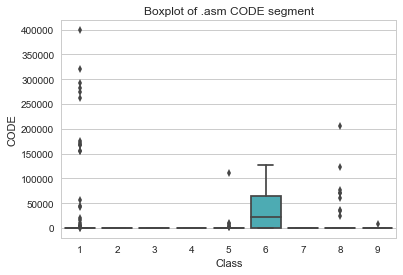

In [42]:
ax = sns.boxplot(x=result1['Class'],y= result1['CODE'])
plt.title("Boxplot of .asm CODE segment")
plt.show()

<pre>
The plot is between CODE and class 
Class 6 can be easly separated 75 percentile files are having 60000 CODE lines
</pre>

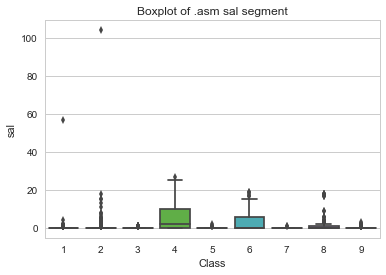

In [45]:
ax = sns.boxplot(x=result1['Class'],y= result1['sal'])
plt.title("Boxplot of .asm sal segment")
plt.show()

<pre>
The plot is between sal and class 
Class 4 and 6 can be easly separated
</pre>

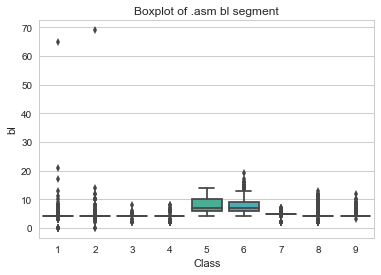

In [46]:
ax = sns.boxplot(x=result1['Class'],y= result1['bl'])
plt.title("Boxplot of .asm bl segment")
plt.show()

<pre>
The plot is between bl and class 
Class 5 and 6 can be easly separated
</pre>

In [47]:
# we normalize the data each column 
result1 = normalize(result1)
result1.head()

,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,bl,bx,ch,cl,cx,dh,dl,dx,Class,size
0,01azqd4InC7m9JpocGv5,0.101695,0.032927,0.0,0.006937,0.542847,0.0,0.000467,0.0,0.000000,...,0.057971,NaN,NaN,0.0,0.0,0.0,NaN,NaN,9,0.400910
1,02IOCvYEy8mjiuAQHax3,0.096045,0.001230,0.0,0.000246,0.030916,0.0,0.000000,0.0,0.000072,...,0.101449,NaN,NaN,0.0,0.0,0.0,NaN,NaN,6,0.023389
2,02zcUmKV16Lya5xqnPGB,0.000000,0.012669,0.0,0.001869,0.010040,0.0,0.250934,0.0,0.000000,...,0.057971,NaN,NaN,0.0,0.0,0.0,NaN,NaN,2,0.256777
3,04hSzLv5s2TDYPlcgpHB,0.101695,0.013575,0.0,0.001468,0.002512,0.0,0.000000,0.0,0.000072,...,0.057971,NaN,NaN,0.0,0.0,0.0,NaN,NaN,8,0.007081
4,05EeG39MTRrI6VY21DPd,0.096045,0.016323,0.0,0.001935,0.000416,0.0,0.000882,0.0,0.000072,...,0.057971,NaN,NaN,0.0,0.0,0.0,NaN,NaN,1,0.006546


<h4> 2.3 Multivariate Analysis on .asm file features </h4>


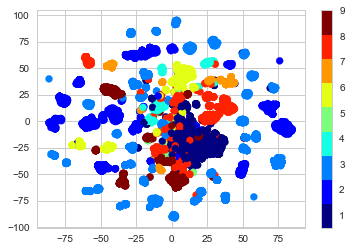

In [49]:
xtsne=TSNE(perplexity=50)
results=xtsne.fit_transform(result1.drop(['ID','Class'], axis=1).fillna(0))
vis_x = results[:, 0]
vis_y = results[:, 1   ]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

<pre>
TSNE for asm data with perplexity 50
</pre>

<h3> 2.4 Train and test split</h3>


In [50]:
asm_y = result1['Class']
asm_x = result1.drop(['ID','Class','rtn','fstcwimul','je','ecx','es','ax','bx','ch','dl','dx','al','proc','DATA','lea','db','dd','dw','int'], axis=1)


In [51]:
X_train_asm, X_test_asm, y_train_asm, y_test_asm = train_test_split(asm_x,asm_y ,stratify=asm_y,test_size=0.20,random_state=42)
X_train_asm, X_cv_asm, y_train_asm, y_cv_asm = train_test_split(X_train_asm, y_train_asm,stratify=y_train_asm,test_size=0.20,random_state=52)

<h3> 2.5 Machine Learning models on features of .asm files</h3>


<h4> 2.5.1 K-Nearest Neigbors </h4>


log_loss for k =  1 is 0.13325904292207555
log_loss for k =  3 is 0.1280744668170482
log_loss for k =  5 is 0.13403406153062572
log_loss for k =  7 is 0.14087028917446134
log_loss for k =  9 is 0.14886256093579942
log_loss for k =  11 is 0.15692853053812836
log_loss for k =  13 is 0.16382515900322936
log_loss for k =  15 is 0.16886481773772077
log_loss for k =  17 is 0.17435653549179475
log_loss for k =  19 is 0.1823992436377429


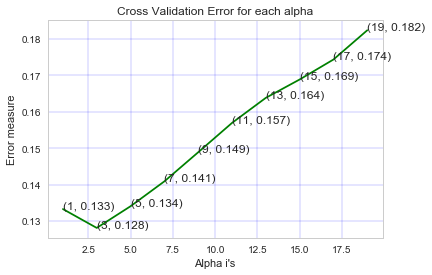

log loss for train data 0.05455437671631938
log loss for cv data 0.1280744668170482
log loss for test data 0.10618753621869148
Number of misclassified points  2.5758969641214353
-------------------------------------------------- Confusion matrix --------------------------------------------------


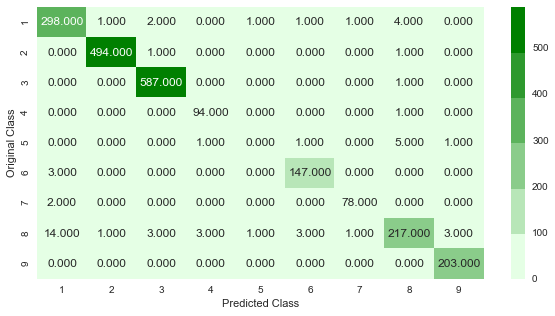

-------------------------------------------------- Precision matrix --------------------------------------------------


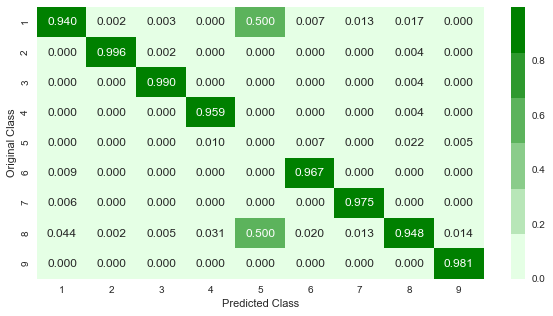

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


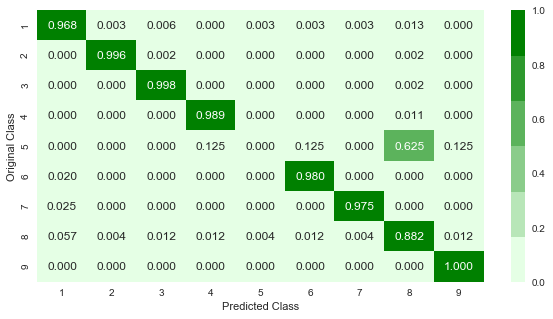

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [52]:
alpha = [x for x in range(1, 21,2)]
cv_log_error_array=[]
for i in alpha:
    k_cfl=KNeighborsClassifier(n_neighbors=i)
    k_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=k_cfl.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

k_cfl=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
k_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
pred_y=sig_clf.predict(X_test_asm)


predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',log_loss(y_train_asm, predict_y))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',log_loss(y_cv_asm, predict_y))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',log_loss(y_test_asm, predict_y))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

<h4> 2.5.2 Logistic Regression </h4>


log_loss for c =  1e-05 is 1.580408974228857
log_loss for c =  0.0001 is 1.556849656011964
log_loss for c =  0.001 is 1.2213545245193849
log_loss for c =  0.01 is 0.810811745710204
log_loss for c =  0.1 is 0.6000891779355783
log_loss for c =  1 is 0.3625438259712482
log_loss for c =  10 is 0.20460481407538492
log_loss for c =  100 is 0.14140115143086487
log_loss for c =  1000 is 0.12204545495645845


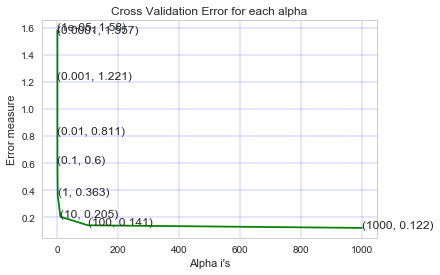

log loss for train data 0.07936245149612503
log loss for cv data 0.12204545495645845
log loss for test data 0.10120670714518387
Number of misclassified points  1.609935602575897
-------------------------------------------------- Confusion matrix --------------------------------------------------


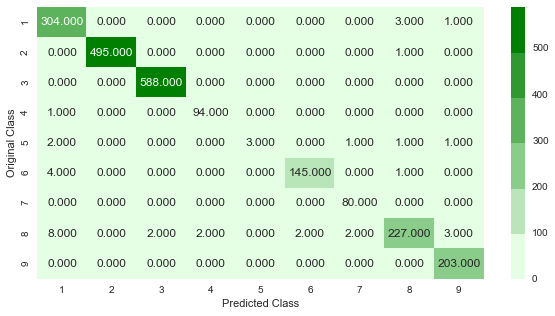

-------------------------------------------------- Precision matrix --------------------------------------------------


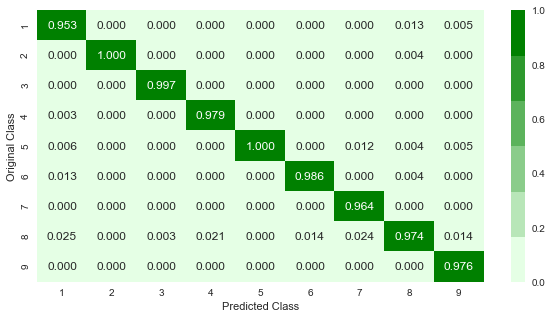

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


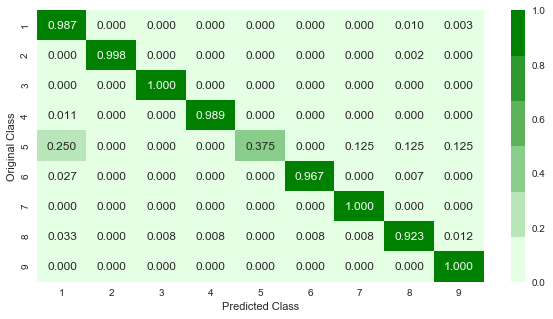

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [53]:
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)

predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',(log_loss(y_train_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',(log_loss(y_cv_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',(log_loss(y_test_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

<h4> 2.5.3 Random Forest Classifier</h4>


log_loss for c =  10 is 0.04747320821185362
log_loss for c =  50 is 0.041616748556043866
log_loss for c =  100 is 0.040613946144187216
log_loss for c =  500 is 0.040129342550542665
log_loss for c =  1000 is 0.03986159478310855
log_loss for c =  2000 is 0.04007684051836278
log_loss for c =  3000 is 0.04020356470901167


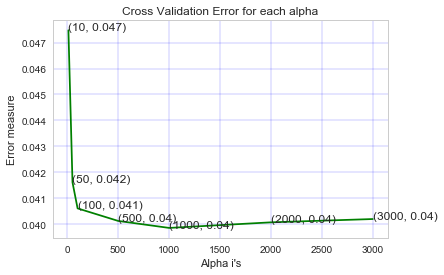

log loss for train data 0.013054770057294236
log loss for cv data 0.03986159478310855
log loss for test data 0.04770682411318043
Number of misclassified points  0.9199632014719411
-------------------------------------------------- Confusion matrix --------------------------------------------------


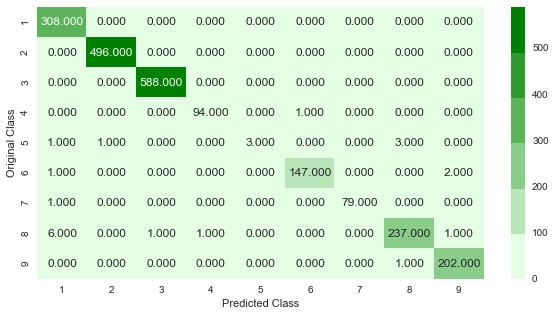

-------------------------------------------------- Precision matrix --------------------------------------------------


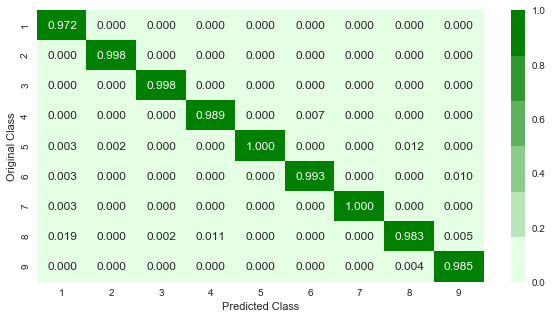

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


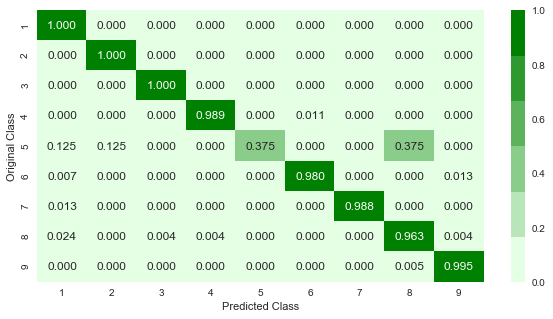

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [54]:
alpha=[10,50,100,500,1000,2000,3000]

cv_log_error_array=[]
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',(log_loss(y_train_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',(log_loss(y_cv_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',(log_loss(y_test_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

<h4> 2.5.4 XgBoost Classifier</h4>


log_loss for c =  10 is 0.08472138140640029
log_loss for c =  50 is 0.050731302504605905
log_loss for c =  100 is 0.041882233599423
log_loss for c =  500 is 0.03838649101907808
log_loss for c =  1000 is 0.03786030170693311
log_loss for c =  2000 is 0.03784009096238211
log_loss for c =  3000 is 0.03796261813946785


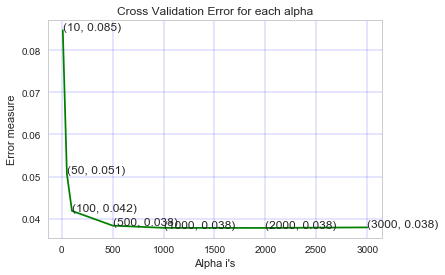

For values of best alpha =  2000 The train log loss is: 0.009772295888356911
For values of best alpha =  2000 The cross validation log loss is: 0.03784009096238211
For values of best alpha =  2000 The test log loss is: 0.0447692823724242
Number of misclassified points  0.6899724011039559
-------------------------------------------------- Confusion matrix --------------------------------------------------


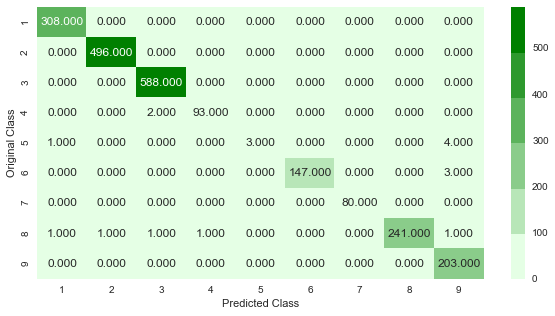

-------------------------------------------------- Precision matrix --------------------------------------------------


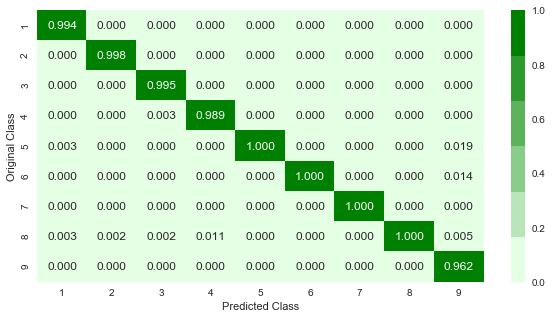

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


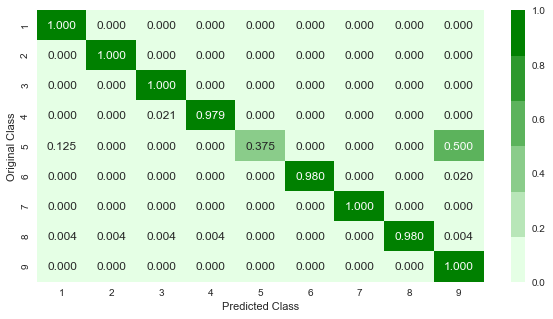

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [56]:
alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
    
predict_y = sig_clf.predict_proba(X_train_asm)

print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_asm, predict_y))
predict_y = sig_clf.predict_proba(X_cv_asm)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_asm, predict_y))
predict_y = sig_clf.predict_proba(X_test_asm)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_asm, predict_y))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

In [57]:
x = PrettyTable()
x.field_names = ["model(54 features)", "train log loss","CV log loss","test log loss","no of misclassified points"]
x.add_row(["KNN",0.048,0.106,0.100,2.20])
x.add_row(["Logistic regression",0.317,0.352,0.324,6.43])
x.add_row(["RF",0.013,0.038,0.048,0.91])
x.add_row(["xgboost",0.011,0.033,0.046,0.68])

In [58]:
y = PrettyTable()
y.field_names = ["model(249 features)", "train log loss","CV log loss","test log loss","no of misclassified points"]
y.add_row(["KNN",0.054,0.128,0.106,2.57])
y.add_row(["Logistic regression",0.079,0.122,0.101,1.60])
y.add_row(["RF",0.013,0.039,0.047,0.91 ])
y.add_row(["xgboost",0.009,0.037,0.044,0.68])

In [60]:
print(x)
print(y)

+---------------------+----------------+-------------+---------------+----------------------------+
|  model(54 features) | train log loss | CV log loss | test log loss | no of misclassified points |
+---------------------+----------------+-------------+---------------+----------------------------+
|         KNN         |     0.048      |    0.106    |      0.1      |            2.2             |
| Logistic regression |     0.317      |    0.352    |     0.324     |            6.43            |
|          RF         |     0.013      |    0.038    |     0.048     |            0.91            |
|       xgboost       |     0.011      |    0.033    |     0.046     |            0.68            |
+---------------------+----------------+-------------+---------------+----------------------------+
+---------------------+----------------+-------------+---------------+----------------------------+
| model(249 features) | train log loss | CV log loss | test log loss | no of misclassified points |
